In [585]:
#This program fits the O-PPAC data onto a FCNN model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime

In [698]:
dataset = h5py.File('simu_HDF_thistimeforReal.h5', 'r') #load data
num_diodes = dataset['Num_diodes'][...] #separate the data into each key within the data file
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
histgrid = histgrid[:-10,:,:] #redefine the shape and size of histgrid by removing the last 10 events
output = np.vstack((x_pos,y_pos)) #define new, single variable for x and y position
output = np.transpose(output) #original definition was sideways, so we transposed it

#values = [117,174]
#list of locations (by index) in histgrid which have unusable data due to peaks being in incorrect/weird locations

new_histgrid = np.delete(histgrid, values, 1)
#histgrid = new_histgrid
#deletes "values" from histgrid and then redefines histgrid to not contain those values
#done as 2 lines so you can comment out the 2nd and compare histgrid to new_histgrid if needed

print(histgrid.shape)

where_are_NaNs = isnan(histgrid) #removes any NaN values within histgrid; shouldn't be a problem with "values" removed
histgrid[where_are_NaNs] = 0

dataset.close()

(991, 342, 132)


In [701]:
def data_compile(histdata):
    data = []  #creates empty arrays for data and labels
    labels = []
    for i in range(histdata.shape[1]):
        for j in range(1,histdata.shape[0]):
            data.append(histdata[j,i,0:132]) #puts histgrid data inside of "data"
            labels.append(output[i]) #puts x,y _pos into "labels"
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)

#to make sure everything is the correct shape
print(all_data.shape)
print(all_labels.shape)

(338580, 132)
(338580, 2)


In [702]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

0.8395246220687987


In [755]:
all_labels = pd.DataFrame(all_labels)
all_data = pd.DataFrame(all_data)
all_data["sum"] = np.sum(all_data, axis = 1)

print(all_data)

print(len(all_labels))
print(len(all_data))

remove_labels = list(all_data[all_data["sum"] == 0].index)

all_labels = all_labels.drop(all_labels.index[remove_labels])
all_data = all_data[all_data["sum"] != 0]

print(len(all_labels))
print(len(all_data))

del all_data['sum']

               0         1         2         3    4    5         6         7  \
0       0.000000  0.003912  0.000000  0.000000  0.0  0.0  0.000000  0.003912   
1       0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
2       0.000000  0.000000  0.003955  0.007909  0.0  0.0  0.007909  0.000000   
3       0.008882  0.000000  0.000000  0.000000  0.0  0.0  0.004441  0.000000   
4       0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
...          ...       ...       ...       ...  ...  ...       ...       ...   
338575  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
338576  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.003650  0.000000   
338577  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
338578  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.002713   
338579  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   

               8         9  ...       1

In [709]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [710]:
print(train_data.ndim)
print(train_data.shape)
print(train_data[0])

2
(270635, 132)
234760    0.0
222876    0.0
315753    0.0
283444    0.0
329684    0.0
         ... 
150373    0.0
190335    0.0
16710     0.0
222224    0.0
215661    0.0
Name: 0, Length: 270635, dtype: float64


In [711]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [712]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.2))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [713]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [714]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=100,
                    batch_size = 32,
                    callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/100
5921/5921 [==============================] - 22s 4ms/step - loss: 4.5845 - mae: 0.6888 - mse: 4.5845 - val_loss: 0.2769 - val_mae: 0.3945 - val_mse: 0.2769
Epoch 2/100
5921/5921 [==============================] - 19s 3ms/step - loss: 0.1853 - mae: 0.3342 - mse: 0.1853 - val_loss: 0.1500 - val_mae: 0.2982 - val_mse: 0.1500
Epoch 3/100
5921/5921 [==============================] - 22s 4ms/step - loss: 0.1186 - mae: 0.2673 - mse: 0.1186 - val_loss: 0.1122 - val_mae: 0.2624 - val_mse: 0.1122
Epoch 4/100
5921/5921 [==============================] - 20s 3ms/step - loss: 0.0857 - mae: 0.2282 - mse: 0.0857 - val_loss: 0.0779 - val_mae: 0.2154 - val_mse: 0.0779
Epoch 5/100
5921/5921 [==============================] - 21s 4ms/step - loss: 0.0690 - mae: 0.2045 - mse: 0.0690 - val_loss: 0.0907 - val_mae: 0.2357 - val_mse: 0.0907
Epoch 6/100
5921/5921 [==============================] - 23s 4ms/step - loss: 0.0578 - mae: 0.1867 - mse: 0.0578 - val_loss: 0.0529 - val_mae: 0.1741 - val_mse:

5921/5921 [==============================] - 22s 4ms/step - loss: 0.0301 - mae: 0.1311 - mse: 0.0301 - val_loss: 0.0259 - val_mae: 0.1178 - val_mse: 0.0259
Epoch 12/100
5921/5921 [==============================] - 20s 3ms/step - loss: 0.0284 - mae: 0.1261 - mse: 0.0284 - val_loss: 0.0259 - val_mae: 0.1187 - val_mse: 0.0259
Epoch 13/100
5921/5921 [==============================] - 20s 3ms/step - loss: 0.0256 - mae: 0.1197 - mse: 0.0256 - val_loss: 0.0270 - val_mae: 0.1214 - val_mse: 0.0270
Epoch 14/100
5921/5921 [==============================] - 20s 3ms/step - loss: 0.0229 - mae: 0.1127 - mse: 0.0229 - val_loss: 0.0323 - val_mae: 0.1374 - val_mse: 0.0323
Epoch 15/100
5921/5921 [==============================] - 21s 4ms/step - loss: 0.0218 - mae: 0.1094 - mse: 0.0218 - val_loss: 0.0214 - val_mae: 0.1029 - val_mse: 0.0214
Epoch 16/100
5921/5921 [==============================] - 23s 4ms/step - loss: 0.0195 - mae: 0.1036 - mse: 0.0195 - val_loss: 0.0276 - val_mae: 0.1220 - val_mse: 0.0276

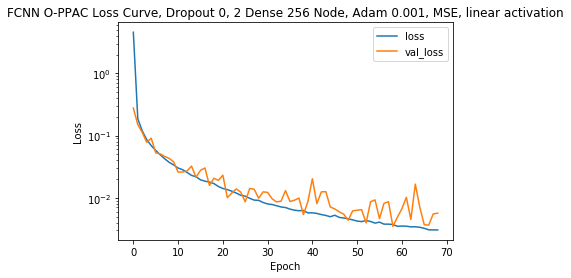

In [715]:
#loss plot of training and test data
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, Adam 0.001, MSE, linear activation")
plt.show()

In [716]:
#separation of 'result' values (stats from test data)
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

2115/2115 - 4s - loss: 0.0042 - mae: 0.0503 - mse: 0.0042


In [717]:
#separation of 'prediction' values (training data)
predictions = FCNN_model.predict(test_data)

In [724]:
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = test_labels[0]
y_test1 = test_labels[1]

x_test = np.array(x_test1)
y_test = np.array(y_test1)


x_test[0]
y_test[0]

-12.0

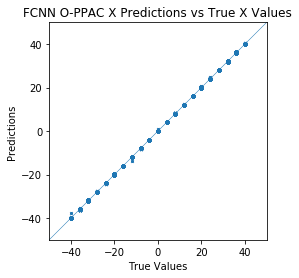

In [757]:
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels, x_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC X Predictions vs True X Values")
plt.show()

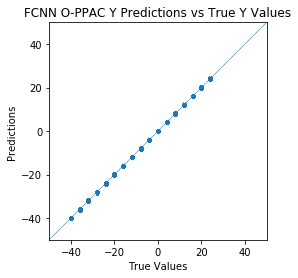

In [758]:
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")
plt.show()

In [739]:
#to find the locations of largest error within my predicted x values
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

xerror_list = [i for i in x_error if abs(i) >= 1]
xerror_list.sort(reverse = True)
print(len(xerror_list))
print(xerror_list)


2
[2.1269989013671875, -1.7860355377197266]
<class 'pandas.core.frame.DataFrame'>


In [754]:
#stuff to fix still

bad_xvalue = 2.1269989013671875
x_test_locat = x_error.index(bad_xvalue)
 
print(x_test_locat)

plt.title('Problem Location Example')
plt.plot(test_data.iloc[[x_test_locat]])
plt.show()

print(test_data[test_data[‘Index’]==x_test_locat].index.values)

print(test_data)

SyntaxError: invalid character in identifier (<ipython-input-754-f4975698a1a7>, line 10)

In [733]:
#to find the locations of largest error within my predicted y values
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

yerror_list = [i for i in y_error if abs(i) >= 1]
yerror_list.sort(reverse = True)
print(len(yerror_list))
print(yerror_list)

0
[]


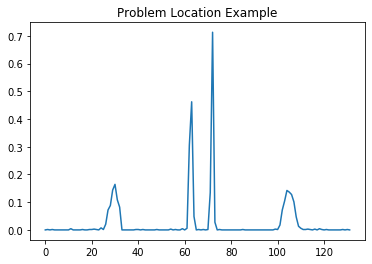

In [570]:
#stuff to fix still

bad_yvalue = 2.532268524169922
y_test_locat = y_error.index(bad_yvalue)

plt.title('Problem Location Example')
plt.plot(test_data[y_test_locat])
plt.show()

In [736]:
#in "bad value" plug in x error value to find the index for x_pos and y_pos
bad_value = 2.1269989013671875
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_value)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_value)])))

print(np.intersect1d(x_locat, y_locat))

#the common value between the x and y arrays is the index of the bad data

#Event locations with 0s: 6, 57, 196
#Event locations with bad peaks: 299

[119]


In [569]:
#in "bad value" plug in y error value to find the index for x_pos and y_pos
bad_value = 20.07520866394043
x_locat = np.where(x_pos == (np.array(x_test[y_error.index(bad_value)])))
y_locat = np.where(y_pos == (np.array(y_test[y_error.index(bad_value)])))

print(np.intersect1d(x_locat, y_locat))

#the common value between the x and y arrays is the index of the bad data


[196]


67656


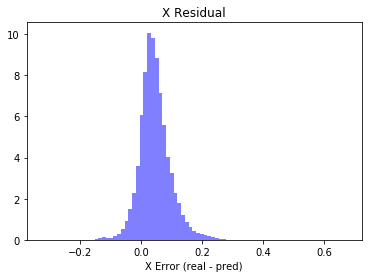

In [734]:
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

#error_list_x = x_error
error_list_x = [i for i in x_error if abs(i) <= .75]
print(len(error_list_x))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')

plt.title(r'X Residual')

plt.show()

67658


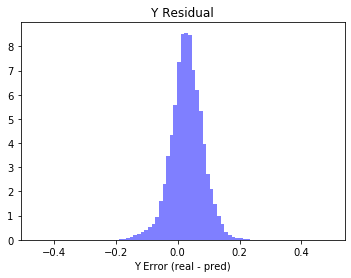

In [735]:
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

#error_list_y = y_error
error_list_y = [i for i in y_error if abs(i) <= .75]
print(len(error_list_y))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_y, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Error (real - pred)')

plt.title(r'Y Residual')
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()